# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
import evaluation_vectorization as ev
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'Seeds'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([210, 7]), torch.Size([210]), 210, 7, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.4410, 0.5021, 0.5708, 0.4865, 0.4861, 0.1893, 0.3452],
        [0.4051, 0.4463, 0.6624, 0.3688, 0.5011, 0.0329, 0.2152],
        [0.3494, 0.3471, 0.8793, 0.2207, 0.5039, 0.2515, 0.1507],
        [0.3069, 0.3161, 0.7931, 0.2393, 0.5339, 0.1942, 0.1408],
        [0.5241, 0.5331, 0.8648, 0.4274, 0.6643, 0.0767, 0.3230],
        [0.3579, 0.3719, 0.7895, 0.2742, 0.4861, 0.2206, 0.2152],
        [0.3872, 0.4298, 0.6515, 0.3739, 0.4483, 0.3668, 0.3447],
        [0.3324, 0.3492, 0.7532, 0.2934, 0.4790, 0.2516, 0.2368],
        [0.5704, 0.6302, 0.6044, 0.6498, 0.5952, 0.1658, 0.6686],
        [0.5524, 0.5868, 0.7250, 0.5546, 0.6237, 0.1565, 0.4993]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))


random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_valid])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_valid-E_test])

len(train_data), len(valid_data), len(test_data)

(126, 42, 42)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Aging Aware PNN

In [11]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

In [12]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [14]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.27321 | Loss: 0.996175587 |
| Epoch:     7 | Accuracy: 0.35857 | Loss: 0.874684334 |
| Epoch:    14 | Accuracy: 0.36893 | Loss: 0.864156663 |
| Epoch:    21 | Accuracy: 0.37583 | Loss: 0.890601277 |
| Epoch:    28 | Accuracy: 0.46286 | Loss: 0.794393182 |
| Epoch:    35 | Accuracy: 0.53357 | Loss: 0.750131786 |
| Epoch:    42 | Accuracy: 0.60036 | Loss: 0.657899201 |
| Epoch:    49 | Accuracy: 0.64536 | Loss: 0.612320185 |
| Epoch:    56 | Accuracy: 0.70893 | Loss: 0.508607268 |
| Epoch:    63 | Accuracy: 0.72131 | Loss: 0.477756560 |
| Epoch:    70 | Accuracy: 0.78155 | Loss: 0.426011622 |
| Epoch:    77 | Accuracy: 0.79714 | Loss: 0.379242867 |
| Epoch:    84 | Accuracy: 0.79583 | Loss: 0.387939841 |
| Epoch:    91 | Accuracy: 0.80690 | Loss: 0.368155926 |
| Epoch:    98 | Accuracy: 0.81488 | Loss: 0.336678803 |
| Epoch:   105 | Accuracy: 0.81786 | Loss: 0.346619070 |
| Epoch:   112 | Accuracy: 0.82417 | Loss: 0.323320389 |
| Epoch:   119 | Accuracy: 0.83

(135, 0.2763008177280426)

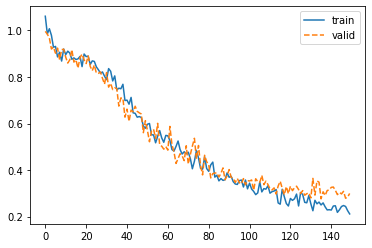

In [15]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

In [16]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_2)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.83381 | Loss: 0.318936914 |
| Epoch:    12 | Accuracy: 0.84976 | Loss: 0.285489380 |
| Epoch:    24 | Accuracy: 0.84548 | Loss: 0.292565167 |
| Epoch:    36 | Accuracy: 0.85405 | Loss: 0.273682773 |
| Epoch:    48 | Accuracy: 0.86393 | Loss: 0.265780419 |
| Epoch:    60 | Accuracy: 0.87060 | Loss: 0.252609760 |
| Epoch:    72 | Accuracy: 0.86881 | Loss: 0.246775508 |
| Epoch:    84 | Accuracy: 0.87119 | Loss: 0.241320536 |
| Epoch:    96 | Accuracy: 0.86690 | Loss: 0.265072316 |
| Epoch:   108 | Accuracy: 0.87952 | Loss: 0.238359809 |
| Epoch:   120 | Accuracy: 0.87619 | Loss: 0.240688905 |
| Epoch:   132 | Accuracy: 0.88190 | Loss: 0.229783401 |
| Epoch:   144 | Accuracy: 0.88083 | Loss: 0.238700733 |
| Epoch:   156 | Accuracy: 0.87857 | Loss: 0.230177313 |
| Epoch:   168 | Accuracy: 0.88250 | Loss: 0.233754814 |
| Epoch:   180 | Accuracy: 0.88845 | Loss: 0.218770221 |
| Epoch:   192 | Accuracy: 0.88857 | Loss: 0.216563851 |
| Epoch:   204 | Accuracy: 0.88

(241, 0.19635553658008575)

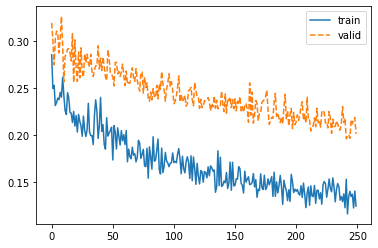

In [17]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

In [18]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_3)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.88952 | Loss: 0.222032577 |
| Epoch:    12 | Accuracy: 0.89762 | Loss: 0.210633248 |
| Epoch:    24 | Accuracy: 0.89964 | Loss: 0.202233747 |
| Epoch:    36 | Accuracy: 0.89500 | Loss: 0.207691237 |
| Epoch:    48 | Accuracy: 0.89833 | Loss: 0.208460778 |
| Epoch:    60 | Accuracy: 0.88857 | Loss: 0.210990638 |
| Epoch:    72 | Accuracy: 0.89690 | Loss: 0.202406794 |
| Epoch:    84 | Accuracy: 0.89571 | Loss: 0.207020894 |
| Epoch:    96 | Accuracy: 0.89048 | Loss: 0.211497471 |
| Epoch:   108 | Accuracy: 0.89940 | Loss: 0.202303931 |
| Epoch:   120 | Accuracy: 0.90214 | Loss: 0.200003922 |
| Epoch:   132 | Accuracy: 0.89524 | Loss: 0.198990732 |
| Epoch:   144 | Accuracy: 0.90000 | Loss: 0.207430854 |
| Epoch:   156 | Accuracy: 0.89405 | Loss: 0.203589901 |
| Epoch:   168 | Accuracy: 0.89643 | Loss: 0.200509802 |
| Epoch:   180 | Accuracy: 0.89500 | Loss: 0.199258417 |
| Epoch:   192 | Accuracy: 0.89881 | Loss: 0.198457420 |
| Epoch:   204 | Accuracy: 0.89

(237, 0.18107838928699493)

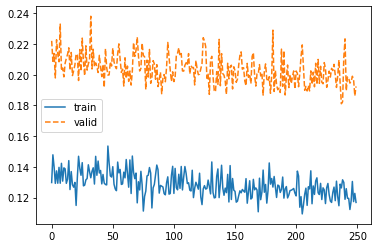

In [19]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

## Save Model

In [20]:
# with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
#     pickle.dump(AAPNN, f)

# Evaluation

In [21]:
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = ev.Evaluation(AAPNN, test_loader, config.M_test, int(config.M_test/10), config.K_test, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
# np.savetxt(f'./result/figures/{ds}_AAPNN_ACC_{seed}_{int(np.mean(mean_acc_AAPNN)*1000)}.txt', np.vstack((mean_acc_AAPNN, std_acc_AAPNN)))
# np.savetxt(f'./result/figures/{ds}_AAPNN_MAA_{seed}_{int(np.mean(mean_maa_AAPNN)*1000)}.txt', np.vstack((mean_maa_AAPNN, std_maa_AAPNN)))